<a href="https://colab.research.google.com/github/masak102710/Pytorch_book/blob/main/pytorch_ch9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install japanize_matplotlib
!pip install torchviz
import torch
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from torchviz import make_dot
import torch.nn as nn
#from torchinfo import summary

import torch.optim as optim
from sklearn.datasets import load_boston
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 4.9 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=38b08eb54ff20feca6a8ed48d2983aa8017a35c60c04524e01f4bd3c5898f286
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=687bfa953775ba49e6a53d86084f009d6db10f52bc208e3fee3483b7bec5e53d
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz
cpu


In [ ]:
def eval_loss(loader,device,net,criterion):
  for images, labels in loader:
    break
  
  inputs = images.to(device)
  labels = labels.to(device)

  outputs = net(inputs)

  loss = criterion(outputs,labels)

  return loss

In [ ]:
def fit(net,optimizer,criterion,num_epochs,train_loader,test_loader,device,history):
  for epoch in range(num_epochs):

    base_epochs = len(history)

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    n_train = 0
    loss_train = 0
    acc_train = 0

    for inputs,labels in tqdm(train_loader):
      n_train+= len(labels)
    
      #GPUに転送
      inputs = inputs.to(device)
      labels = labels.to(device)
    
      #勾配初期化
      optimizer.zero_grad()

      #forward計算
      outputs = net(inputs)

      #誤差関数
      loss = criterion(outputs,labels)

      #勾配計算
      loss.backward()

      #パラメータ修正
      optimizer.step()
    
      #精度計算
      loss_train += loss.item()
      
      predicted_train = torch.max(outputs,1)[1]
      acc_train += (predicted_train == labels).sum().item()

    #保存用定義
    n_test = 0
    acc_test = 0
    loss_test2 = 0

    for inputs_test,labels_test in test_loader:
      n_test += len(labels_test)

      #GPUに転送
      inputs_test = inputs_test.to(device)
      labels_test = labels_test.to(device)
    
      #forward計算
      outputs_test = net(inputs_test)
    
      #loss計算
      loss_test1 = criterion(outputs_test,labels_test)

      #精度計算
      predicted_test = torch.max(outputs_test,1)[1]

      loss_test2 += loss_test1.item()
      acc_test += (predicted_test == labels_test).sum().item()
      
    #保存用
    item = [epoch ,loss_train/n_train ,acc_train/n_train ,loss_test2/n_test ,acc_test/n_test]
    history = np.vstack((history,item))
    print(f'回数:{epoch},損失関数(train):{loss_train/n_train}:正答率(train):{acc_train/n_train}')
    print(f'回数:{epoch},損失関数(test ):{loss_test2/n_test}:正答率(test):{acc_test/n_test}')

  return history

In [ ]:
def show_image_labels(loader,net,device,classes):

  #loaderからデータ読込
  for images,labels in loader:
    break

  #devise指定あれば転送
  if device is not None:
    images.to(device)
    labels.to(device)

  #forward計算
  if net is not None:
    outputs = net(images)
    predicted = torch.max(outputs,1)[1]

  #image表示
  plt.figure(figsize=(10,5))
  for i in range(50):
    ax = plt.subplot(5,10,i+1)
    plt_image = images[i].numpy() #numpyに変換
    plt_image2 = np.transpose(plt_image,(1,2,0)) #行列の読込方
    plt_image3 = (plt_image2+1)/2 #正規化を戻す
    plt_label = labels[i]

    #ラベル表示,
    if net is not None:
      if(plt_label.item()==predicted[i].item()):
          plt.title(f'{classes[predicted[i]]}') #正解
      else:
          plt.title(f'{classes[predicted[i]]}',color='red') #不正解
    else:
      plt.title(f'{classes[plt_label]}') #netない場合
    
    plt.imshow(plt_image3)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.tight_layout()
  plt.show()

In [ ]:
def plot_history(history):
  plt.plot(history[:,0],history[:,1],label = 'test') #loss_test
  plt.plot(history[:,0],history[:,3],label = 'train') #train_test

  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('loss',fontsize = 18)
  plt.legend(fontsize = 18)
  
  plt.show()


  plt.plot(history[:,0],history[:,2],label = 'test') #acc_test
  plt.plot(history[:,0],history[:,4],label = 'train') #train_test
  
  plt.xlabel('epoch')
  plt.ylabel('acc')
  plt.title('acc',fontsize = 18)
  plt.legend(fontsize = 18)
  
  plt.ylim(0,1)
  plt.show()

In [ ]:
#1次元行列
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

#3次元行列
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)    
])

data_root = './data'

train_set1 = datasets.CIFAR10(
    root = data_root,train = True,download = True,transform = transform1
)

train_set2 = datasets.CIFAR10(
    root = data_root,train = True,download = True,transform = transform2
)

test_set1 = datasets.CIFAR10(
    root = data_root,train = False,download = True,transform = transform1
)

test_set2 = datasets.CIFAR10(
    root = data_root,train = False,download = True,transform = transform2
)

classes = ('plane','car','bird','cat','deer','dog','frog',
           'horse','ship','truck')

print(classes[1])

In [ ]:

batch_size = 200

train_loader1 = DataLoader(train_set1,shuffle=True,batch_size=batch_size)
train_loader2 = DataLoader(train_set2,shuffle=True,batch_size=batch_size)
test_loader1 = DataLoader(test_set1,shuffle=True,batch_size=batch_size)
test_loader2 = DataLoader(test_set2,shuffle=True,batch_size=batch_size)

show_image_labels(train_loader2,None,None,classes)

In [ ]:
class Net(nn.Module):
  def __init__(self,n_input,n_output,n_hidden):
    super().__init__()

    self.l1 = nn.Linear(n_input,n_hidden)

    self.l2 = nn.Linear(n_hidden,n_output)

    self.relu = nn.ReLU(inplace= True)

  def forward(self,x):
    x1 = self.l1(x)
    x2 = self.l2(x1)
    x3 = self.relu(x2)

    return x3

In [ ]:
n_input = 32 * 32 * 3
n_hidden = 128
n_output = len(classes)

net = Net(n_input,n_output,n_hidden)

lr = 0.01

num_epochs = 50

optimizer = optim.SGD(net.parameters(),lr = lr)

criterion = nn.CrossEntropyLoss()

history = np.zeros((0,5))

#history = fit(net,optimizer,criterion,num_epochs,train_loader1,
#    test_loader1,device,history)


In [ ]:
plot_history(history)

In [ ]:
class CNN(nn.Module):
  def __init__(self,n_output,n_hidden):
    super().__init__()
    self.Conv1 = nn.Conv2d(3,32,3)
    self.Conv2 = nn.Conv2d(32,32,3)
    self.relu = nn.ReLU(inplace = True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.Flatten = nn.Flatten()
    self.l1 = nn.Linear(6272,n_hidden)
    self.l2 = nn.Linear(n_hidden,n_output)

    self.features = nn.Sequential(
        self.Conv1,
        self.relu,
        self.Conv2,
        self.relu,
        self.maxpool
    )

    self.classifer = nn.Sequential(
        self.l1,
        self.relu,
        self.l2
    )

  def forward(self,x):
    x1 = self.features(x)
    x2 = self.Flatten(x1)
    x3 = self.classifer(x2)
    return x3

  0%|          | 0/250 [00:00<?, ?it/s]

回数:0,損失関数(train):0.007367783019542694:正答率(train):0.47328
回数:0,損失関数(test ):0.006191552805900574:正答率(test):0.5549


  0%|          | 0/250 [00:00<?, ?it/s]

回数:1,損失関数(train):0.005618941013813019:正答率(train):0.60272
回数:1,損失関数(test ):0.0055230838477611545:正答率(test):0.6082


  0%|          | 0/250 [00:00<?, ?it/s]

回数:2,損失関数(train):0.004762957918643952:正答率(train):0.66598
回数:2,損失関数(test ):0.0048327553987503056:正答率(test):0.6649


  0%|          | 0/250 [00:00<?, ?it/s]

回数:3,損失関数(train):0.004135530860424042:正答率(train):0.70786
回数:3,損失関数(test ):0.004558080530166626:正答率(test):0.6856


  0%|          | 0/250 [00:00<?, ?it/s]

回数:4,損失関数(train):0.00360377534866333:正答率(train):0.74542
回数:4,損失関数(test ):0.004637544882297516:正答率(test):0.6808


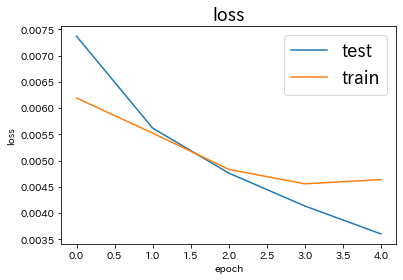

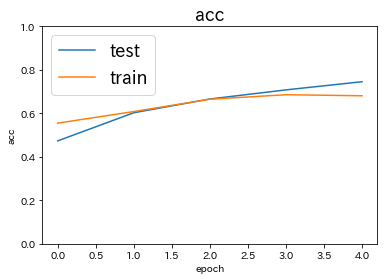

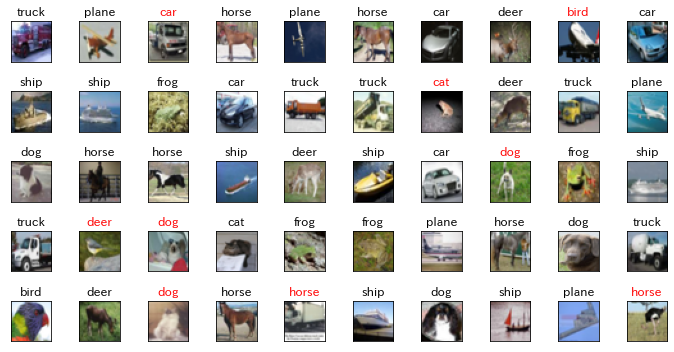

In [ ]:
n_hidden = 128
n_output = 10

net = CNN(n_output,n_hidden).to(device)

lr = 0.1

num_epochs = 5

optimizer2 = optim.Adam(net.parameters())

criterion = nn.CrossEntropyLoss()

history=np.zeros((0,5))

history = fit(net,optimizer2,criterion,num_epochs,
              train_loader2,test_loader2,device,history)

plot_history(history)

show_image_labels(train_loader2,net,device,classes)